In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):

    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)

    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )

def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)



In [4]:
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)


Compiling model...
'compile' took 0.491425 s

Training model...

Step      Train loss              Test loss               Test metric
1013      [1.51e-02, 1.65e-03]    [1.51e-02, 1.54e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.016789
  Number of iterations: 2
  Number of functions evaluations: 24
1037      [1.51e-02, 1.65e-03]    [1.51e-02, 1.54e-03]    []  

Best model at step 1037:
  train loss: 1.68e-02
  test loss: 1.67e-02
  test metric: []

'train' took 1.282361 s



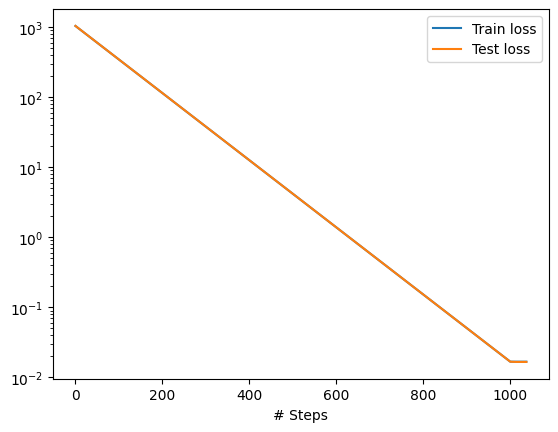

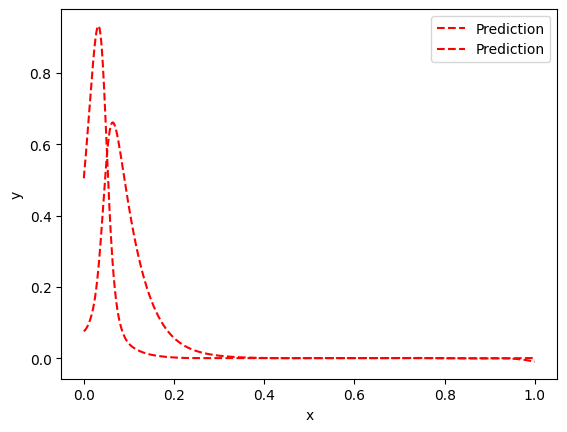

In [7]:
model.compile("L-BFGS", lr=0.01)
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [9]:
x_true, y_true = gen_truedata()

t = np.linspace(0, 1, 100)

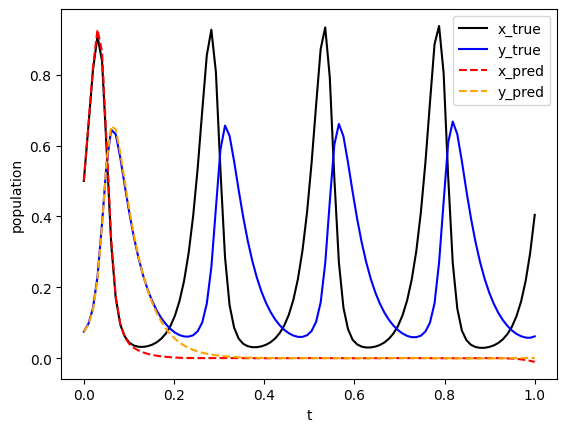

In [10]:
plt.xlabel("t")
plt.ylabel("population")

plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()